<a href="https://colab.research.google.com/github/gaurinotgauri/one-pixel-attack-Differerntial_Evolution/blob/master/one_pixel_attack_Differerntial_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install np_utils
!pip uninstall scipy -y
!pip install scipy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 834.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=c3822b4cf7ea275ae0cfba51afe7d10a365b822f8a66f94296b68741d1b61643
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils
Found existing installation: scipy 1.11.4
Uninstalling scipy-1.11.4:
  Successfully uninstalled scipy-1.11.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 16.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import pickle
import keras
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

In [3]:
!git clone https://github.com/gaurinotgauri/one-pixel-attack-keras

Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 415 (delta 39), reused 50 (delta 24), pack-reused 340
Receiving objects: 100% (415/415), 46.59 MiB | 29.04 MiB/s, done.
Resolving deltas: 100% (237/237), done.


Forked from github.com/sreedath/one-pixel-attack-keras

In [4]:
import os
os.chdir('/content/one-pixel-attack-keras')

In [5]:
#From repository
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

In [6]:
#loading CIFAR10 dataset with 10 distinct classes having 32 x 32 pixel images
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

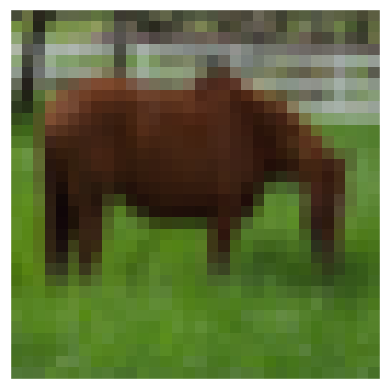

In [26]:
#Example image from the dataset
image_id = 561
helper.plot_image(x_test[image_id])

In [29]:
#Choosing model
lenet = LeNet()
resnet = ResNet()
models = [lenet, resnet]
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])
network_stats

Successfully loaded lenet
Successfully loaded resnet
Evaluating lenet
79/79 [==============================] - 2s 22ms/step
Evaluating resnet
79/79 [==============================] - 44s 550ms/step


,name,accuracy,param_count
0,lenet,0.7488,62006
1,resnet,0.9231,470218


In [31]:
#Perturbation function
def perturb_image(xs, img):

    if xs.ndim < 2:
        xs = np.array([xs])

    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

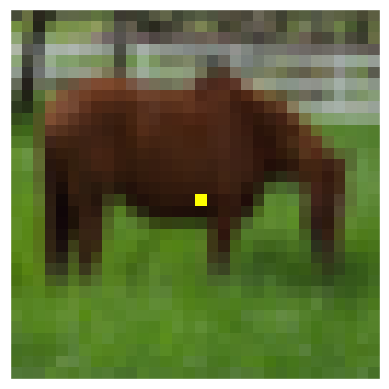

In [33]:
#Perturbed image
pixel = np.array([16, 16, 255, 255, 0])
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
helper.plot_image(image_perturbed)

In [34]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

1/1 [==============================] - 0s 27ms/step
Original confidence was 99.99233484268188 % that it is a cat
Confidence after perturbation is 93.71358752250671 % that it is a cat


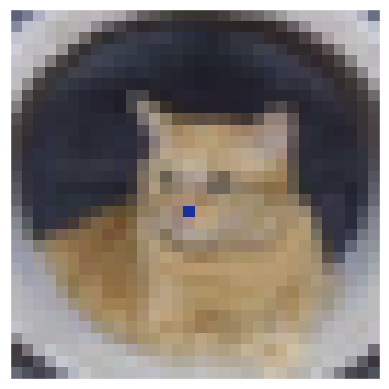

In [39]:
#Checking confidence loss for an image manualy perturbing with 1 pixel
image_id = 4500
pixel = np.array([17, 15,  25, 48, 156])
model = resnet

# Prediction for original image
true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

# Prediction for perturbed image
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
predicted_probs = model.predict_one(image_perturbed)
new_class = np.argmax(predicted_probs)
new_class_confidence = predicted_probs[new_class]

print('Original confidence was', prior_confidence * 100, '% that it is a', class_names[true_class])
print('Confidence after perturbation is', confidence * 100, '% that it is a', class_names[true_class])

helper.plot_image(image_perturbed)  # Plot the perturbed image


In [41]:
#Differential Evolution to find the best positon for perturbation to decrease the confidence

def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    print()
    # If the prediction is what we want (misclassification or targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

def attack(img_id, model, target=None, pixel_count=1,
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]

    # Define bounds for a flat vector of x,y,r,g,b values
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count

    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))

    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class,
                               model, target is None)

    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class,
                              model, targeted_attack, verbose)

    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

1/1 [==============================] - 0s 40ms/step
Original confidence was 99.98511075973511 % that it is a cat
1/1 [==============================] - 0s 27ms/step

Confidence: 0.59906137
1/1 [==============================] - 0s 27ms/step

Confidence: 0.59906137
1/1 [==============================] - 0s 26ms/step

Confidence: 0.59906137
1/1 [==============================] - 0s 43ms/step

Confidence: 0.59906137
1/1 [==============================] - 0s 28ms/step

Confidence: 0.4866655
1/1 [==============================] - 0s 27ms/step


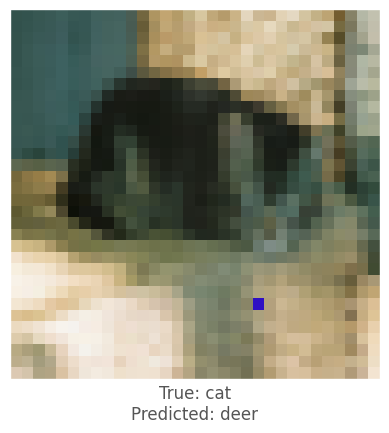

In [48]:
#Testing on an image
image_id = 8600
pixels = 1 # Number of pixels to attack
model = resnet
true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
print('Original confidence was', prior_confidence*100,'% that it is a',class_names[true_class])
_ = attack(image_id, model, pixel_count=pixels, verbose=True)
